In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import csv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [13]:
# Paths
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
EXP_DIR = BASE_DIR / "experiments"
EXP_DIR.mkdir(exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"


In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST(
    root=DATA_DIR, train=True, download=False, transform=transform
)
test_set = datasets.MNIST(
    root=DATA_DIR, train=False, download=False, transform=transform
)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [15]:
class FFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [16]:
class NoisyTopKRouter(nn.Module):
    def __init__(self, input_dim, num_experts, k=2, noise_std=1.0, temperature=1.0):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_experts)
        self.k = k
        self.noise_std = noise_std
        self.temperature = temperature

    def forward(self, x):
        logits = self.linear(x) / self.temperature

        if self.training:
            noise = torch.randn_like(logits) * self.noise_std
            logits = logits + noise

        topk_vals, topk_idx = torch.topk(logits, self.k, dim=-1)
        gates = F.softmax(topk_vals, dim=-1)

        sparse_gates = torch.zeros_like(logits)
        sparse_gates.scatter_(1, topk_idx, gates)

        router_confidence = gates.max(dim=-1).values.mean()

        return sparse_gates, topk_idx, router_confidence


In [17]:
class Expert(nn.Module):
    def __init__(self, input_dim=256, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.net(x)


In [18]:
class SparseMoELayer(nn.Module):
    def __init__(self, input_dim, num_experts=8, k=2, capacity_factor=1.25):
        super().__init__()
        self.num_experts = num_experts
        self.capacity = int(capacity_factor * (64 / num_experts))  # batch-aware
        self.router = NoisyTopKRouter(input_dim, num_experts, k=k)
        self.experts = nn.ModuleList(
            [Expert(input_dim) for _ in range(num_experts)]
        )

    def forward(self, x):
        gates, topk_idx, confidence = self.router(x)

        expert_outputs = torch.zeros_like(x)
        load = torch.zeros(self.num_experts, device=x.device)

        for expert_id in range(self.num_experts):
            mask = gates[:, expert_id] > 0
            tokens = x[mask]

            if tokens.shape[0] == 0:
                continue

            if tokens.shape[0] > self.capacity:
                tokens = tokens[: self.capacity]

            load[expert_id] = tokens.shape[0]

            out = self.experts[expert_id](tokens)
            expert_outputs[mask][: out.shape[0]] += out

        # Load-balancing loss (entropy)
        load_dist = load / (load.sum() + 1e-8)
        load_loss = (load_dist * torch.log(load_dist + 1e-8)).sum()

        return expert_outputs, load_loss, load_dist, confidence


In [19]:
class FFN_MoE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.moe = SparseMoELayer(256, num_experts=8, k=2)
        self.fc_out = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        moe_out, load_loss, load_dist, confidence = self.moe(x)
        x = x + moe_out  # residual

        return self.fc_out(x), load_loss, load_dist, confidence


In [24]:
EPOCHS = 5
LOAD_LOSS_WEIGHT = 0.01

history = {
    "train_loss": [],
    "train_acc": [],
    "router_conf": [],
    "load_dist": []
}


In [25]:
for epoch in range(EPOCHS):
    model.train()

    total_loss = 0.0
    total_acc = 0.0
    load_logs = []
    conf_logs = []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        logits, load_loss, load_dist, conf = model(x)

        loss = criterion(logits, y) + LOAD_LOSS_WEIGHT * load_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        total_acc += (logits.argmax(1) == y).float().mean().item()

        load_logs.append(load_dist.detach().cpu())
        conf_logs.append(conf.item())

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    avg_conf = sum(conf_logs) / len(conf_logs)
    avg_load = torch.stack(load_logs).mean(dim=0)

    history["train_loss"].append(avg_loss)
    history["train_acc"].append(avg_acc)
    history["router_conf"].append(avg_conf)
    history["load_dist"].append(avg_load)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Loss: {avg_loss:.4f} | "
        f"Acc: {avg_acc:.4f} | "
        f"RouterConf: {avg_conf:.3f}"
    )
print("Expert usage (avg):", history["load_dist"][-1])
print("Sum:", history["load_dist"][-1].sum())



Epoch [1/5] Loss: 0.0500 | Acc: 0.9780 | RouterConf: 0.681
Epoch [2/5] Loss: 0.0296 | Acc: 0.9842 | RouterConf: 0.688
Epoch [3/5] Loss: 0.0180 | Acc: 0.9872 | RouterConf: 0.695
Epoch [4/5] Loss: 0.0076 | Acc: 0.9908 | RouterConf: 0.698
Epoch [5/5] Loss: 0.0033 | Acc: 0.9918 | RouterConf: 0.704
Expert usage (avg): tensor([0.1381, 0.1381, 0.1225, 0.0650, 0.1354, 0.1376, 0.1327, 0.1306])
Sum: tensor(1.)


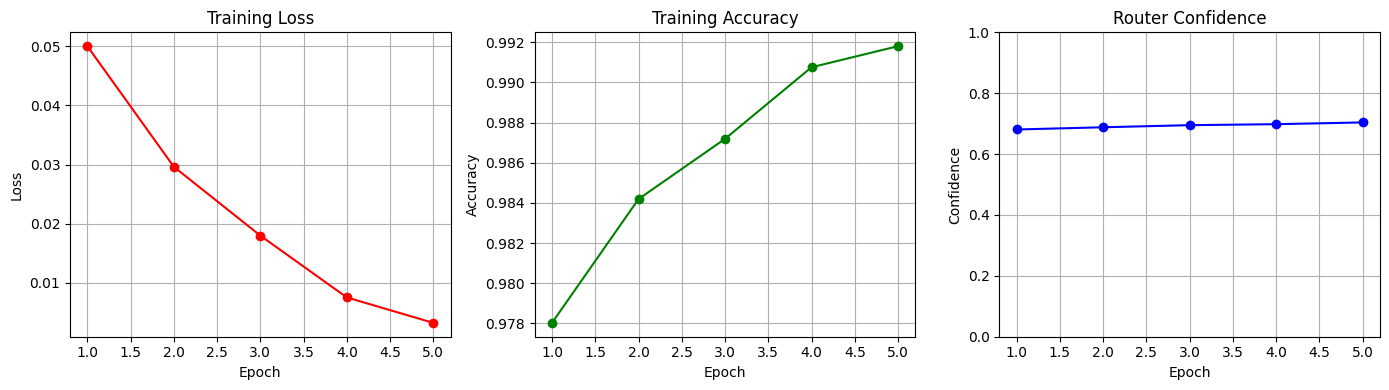

In [26]:
epochs = range(1, EPOCHS + 1)

# Plot Train Loss
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, history["train_loss"], marker='o', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Plot Train Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, history["train_acc"], marker='o', color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

# Plot Router Confidence
plt.subplot(1, 3, 3)
plt.plot(epochs, history["router_conf"], marker='o', color='blue')
plt.title("Router Confidence")
plt.xlabel("Epoch")
plt.ylabel("Confidence")
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.show()


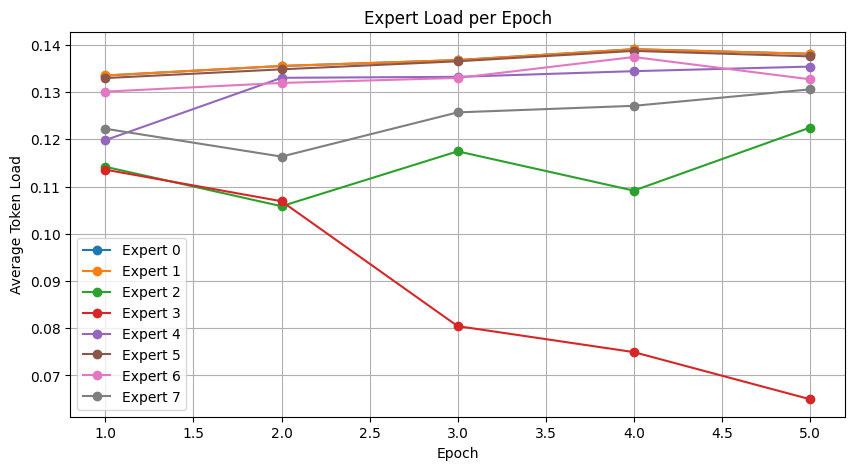

In [27]:
# Convert list of tensors to numpy array
load_per_epoch = np.array([ld.numpy() for ld in history["load_dist"]])
plt.figure(figsize=(10,5))
for expert_id in range(load_per_epoch.shape[1]):
    plt.plot(epochs, load_per_epoch[:, expert_id], marker='o', label=f"Expert {expert_id}")
plt.title("Expert Load per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Token Load")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
def evaluate(model):
    model.eval()
    correct, total = 0, 0

    start = time.time()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits, _, _, _ = model(x)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    latency = time.time() - start

    return correct / total, latency


In [29]:
csv_path = EXP_DIR / "results.csv"
write_header = not csv_path.exists()

test_acc, latency = evaluate(model)
train_loss, train_acc, _, _ = train_epoch(model)
model_size = sum(p.numel() for p in model.parameters()) / 1e6

with open(csv_path, "a", newline="") as f:
    writer = csv.writer(f)
    if write_header:
        writer.writerow(["Model", "Test Accuracy", "Train Accuracy", "Loss", "Size(M)", "Latency(s)"])
    writer.writerow(["Sparse_MoE", test_acc, train_acc, train_loss, model_size, latency])


In [30]:
print(model_size, latency)

0.732946 3.957231283187866


In [ ]:
model.eval()
routing_map = torch.zeros(10, 8)

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        _, _, load_dist, _ = model(x)

        for cls in range(10):
            routing_map[cls] += load_dist.cpu()

routing_map /= routing_map.sum(dim=1, keepdim=True)


In [31]:
model.eval()
routing_map = torch.zeros(10, 8)

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        _, _, load_dist, _ = model(x)

        for cls in range(10):
            routing_map[cls] += load_dist.cpu()

routing_map /= routing_map.sum(dim=1, keepdim=True)


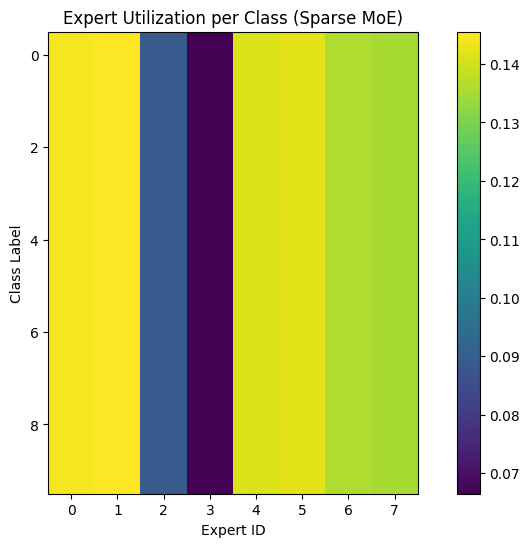

In [32]:
plt.figure(figsize=(10, 6))
plt.imshow(routing_map, cmap="viridis")
plt.colorbar()
plt.xlabel("Expert ID")
plt.ylabel("Class Label")
plt.title("Expert Utilization per Class (Sparse MoE)")
plt.show()


In [33]:
# Path to save model
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(exist_ok=True)
MOE_MODEL_PATH = MODEL_DIR / "sparse_moe_mnist.pth"

# Save model state_dict (recommended for PTQ later)
torch.save(model.state_dict(), MOE_MODEL_PATH)

print(f"Sparse MoE model saved to: {MOE_MODEL_PATH}")


Sparse MoE model saved to: ../models/sparse_moe_mnist.pth
